In [1]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import voc_data
import importlib
import config
import math
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

importlib.reload(voc_data)
importlib.reload(config)

config = config.Config()
image_size = config.image_size[0]
anchor_num = len(config.scales) * len(config.ratios) # 一个锚点对应的anchor数量
anchors = voc_data._anchors

Using TensorFlow backend.


56
21
56
21


In [ ]:
imgList, bboxList, class_idList, rpn_matchList, rpn_bboxesList, maxTwoNum, anchorsList = voc_data.getAllImage()
print(len(imgList))
print(maxTwoNum)
print(maxTwoNum / (1))

In [2]:
class BatchNorm(KL.BatchNormalization):
    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)

# ResNet网络 的building_block
# filter：卷积核的通道数
# block：block的标识
def building_block(filters, block):
    if block != 0:
        stride = 1
    else:
        stride = 2
    
    def f(x):
        y = KL.Conv2D(filters, (1,1), strides=stride)(x)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(filters, (3,3), padding="same")(y)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(4 * filters, (1,1))(y)
        y = BatchNorm(axis=3)(y)
        
        if block == 0:
            # 保证shorcut的filters和上面y的filters个数一致
            shorcut = KL.Conv2D(4 * filters, (1,1), strides=stride)(x)
            shorcut = BatchNorm(axis=3)(shorcut)
        else:
            shorcut = x

        # 结合两个支路的输出
        y = KL.Add()([y, shorcut])
        y = KL.Activation("relu")(y)
        return y
    return f

# ResNet网络
def resNet_featureExtractor(inputs):
    filters = 64   # 第一个卷积核的通道数
    x = KL.Conv2D(filters, (2,2), strides=2)(inputs)
    x = BatchNorm(axis=3)(x)
    x = KL.Activation("relu")(x)

    # resnet50
    blocks = [8, 8, 8]    # buildblock的数量  change
    
    for i, block_num in enumerate(blocks):
        for block_id in range(block_num):
            x = building_block(filters, block_id)(x)
        filters = filters * 2
    return x

def rpn_net(inputs, k):
    shared_map = KL.Conv2D(256, (3,3), padding="same")(inputs)
    shared_map = KL.Activation("linear")(shared_map)
    rpn_class = KL.Conv2D(2 * k, (1,1))(shared_map)
    rpn_class = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 2]))(rpn_class)
    rpn_class = KL.Activation("linear")(rpn_class)
    # 分类的得分
    rpn_prob = KL.Activation("softmax")(rpn_class)
    
    y = KL.Conv2D(4*k, (1,1))(shared_map)
    y = KL.Activation("linear")(y)
    # 边框的得分
    rpn_bbox = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0], -1, 4]))(y)
    
    return rpn_class, rpn_prob, rpn_bbox

In [3]:
x = KL.Input((config.image_size[0], config.image_size[0], 3))  # change
fp = resNet_featureExtractor(x)
rpn_class, rpn_prob, rpn_bbox = rpn_net(fp, anchor_num)
model = Model([x], [rpn_class, rpn_prob, rpn_bbox])
model.summary()
# plot_model(model, to_file="model/model.png", show_shapes=True)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm_1 (BatchNorm)        (None, 160, 160, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 160, 64) 0           batch_norm_1[0][0]               
__________________________________________________________________________________________________
conv2d_

In [4]:
# x：rpn_box，counts：anchor为1的个数，num_rows = len(counts)：总共多少个
# 小函数，取出rpn_box前面有值的“偏移量”
def batch_back(x, counts, num_rows):
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)

# 分类loss
# rpn_match：真实下标  rpn_class_logits：实际计算出的结果
def rpn_class_loss(rpn_match, rpn_class_logits):
    # 压缩最后一维，变成一维的坐标，rpn_match (None, 576, 1) => (None, 576) 
    rpn_match = tf.squeeze(rpn_match, -1)
    # 取出 -1 和 1 的坐标
    indices = tf.where(K.not_equal(rpn_match, 0))
    # 把 -1 和 0 变成 0， 1 还是 1
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    # 取出实际计算出的所有-1 和 1坐标的anchor
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)     ### prediction
    # 取出真实下标的所有-1 和 1坐标的anchor => 现在是（0, 1）0：表示背景 1：表示前景
    anchor_class = tf.gather_nd(anchor_class, indices)   ### target
    # 计算loss
    loss = K.sparse_categorical_crossentropy(target=anchor_class, output=rpn_class_logits, from_logits=True)
    # 计算平均，如果loss算出东西了，就取平均，如果没算出东西，就取0
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

# 回归loss
# target_bbox：真实的边框, rpn_match：真实的anchor下标, rpn_bbox：实际计算出来的结果边框
def rpn_bbox_loss(target_bbox, rpn_match, rpn_bbox):
    # 压缩最后一维，变成一维的坐标，rpn_match (None, 576, 1) => (None, 576) 
    rpn_match = tf.squeeze(rpn_match, -1)
    # 取出 1 的坐标
    indices = tf.where(K.equal(rpn_match, 1))
    # 取出所有 1 的“偏移量”
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)
    # 得出为 1 的“偏移量”的个数
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    # 取出 target_bbox 中为1的“偏移量”
    target_bbox = batch_back(target_bbox, batch_counts, config.batch_size)
    # 求误差
    diff = K.abs(target_bbox - rpn_bbox)
    # 取出小于1的部分
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    # 小于1的部分给抛物线  diff**2
    # 大于1的部分给直线（不会对大的误差敏感） diff-0.5
    loss = (less_than_one * 0.5 * diff**2) + ((1 - less_than_one) * (diff - 0.5))
    # 计算平均，如果loss算出东西了，就取平均，如果没算出东西，就取0
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

# 图片的输入
input_image = KL.Input(shape=[config.image_size[0], config.image_size[0],3], dtype=tf.float32)  # change
# 真实的边框输入
input_bboxes = KL.Input(shape=[None, 4], dtype=tf.float32)
# 真实的分类输入
input_class_ids = KL.Input(shape=[None], dtype=tf.int32)
# 真实的anchor分类 -1,0,1输入
input_rpn_match = KL.Input(shape=[None, 1], dtype=tf.int32)
# 真实的anchor偏移量输入
input_rpn_bbox = KL.Input(shape=[None, 4], dtype=tf.float32)


# 创建模型
feature_map = resNet_featureExtractor(input_image)
# 模型计算出的结果 rpn_class，rpn_prob，rpn_bbox
rpn_class, rpn_prob, rpn_bbox = rpn_net(feature_map, anchor_num)
# 分类loss
loss_rpn_match = KL.Lambda(lambda x: rpn_class_loss(*x), name="loss_rpn_match")(
    [input_rpn_match, rpn_class]
)
loss_rpn_bbox = KL.Lambda(lambda x:rpn_bbox_loss(*x), name="loss_rpn_bbox")(
    [input_rpn_bbox, input_rpn_match, rpn_bbox]
)
model = Model(
    [input_image, input_bboxes, input_class_ids, input_rpn_match, input_rpn_bbox],
    [rpn_class, rpn_prob, rpn_bbox, loss_rpn_match, loss_rpn_bbox]
)
# 添加loss层
loss_lay1 = model.get_layer("loss_rpn_match").output
loss_lay2 = model.get_layer("loss_rpn_bbox").output
model.add_loss(tf.reduce_mean(loss_lay1))
model.add_loss(tf.reduce_mean(loss_lay2))
# 编译
model.compile(loss = [None] * len(model.output), optimizer=keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False))
# 打印出两个loss的收敛情况
model.metrics_names.append("loss_rpn_match")
model.metrics_tensors.append(tf.reduce_mean(loss_lay1, keep_dims=True))
model.metrics_names.append("loss_rpn_bbox")
model.metrics_tensors.append(tf.reduce_mean(loss_lay2, keep_dims=True))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [5]:
# celeba
# def data_Gen(num_batch, batch_size, config):
#     print("----------------")
#     index = 0
#     for iii in range(num_batch):
#         images = []
#         bboxes = []
#         class_ids = []
#         rpn_matchs = []
#         rpn_bboxes = []
#         for i in range(batch_size):
#             image, bbox, class_id, rpn_match, rpn_bbox = imgList[index], bboxList[index], class_idList[index], rpn_matchList[index], rpn_bboxesList[index]
#             pad_num = config.max_gt_obj - bbox.shape[0]
#             pad_box = np.zeros((pad_num, 4))
#             pad_ids = np.zeros((pad_num, 1))
#             bbox = np.concatenate([bbox, pad_box], axis=0)
#             class_id = np.concatenate([class_id, pad_ids], axis=0)
        
#             images.append(image)
#             bboxes.append(bbox)
#             class_ids.append(class_id)
#             rpn_matchs.append(rpn_match)
#             rpn_bboxes.append(rpn_bbox)
#             index += 1
#             # 数据下标大于9996，重置为0
#             if index >= 16000:
#                 index = 0

# #         print("数据：" + str(index))
#         images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
#         bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
#         class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
#         rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
#         rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
#         yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]
# total = 200000          # 总数据
# steps_per_epoch = 20   # 步长
# dataGen = data_Gen(int(total), config.batch_size, config) # 10000个数据，batch_size=10
# voc
def data_Gen(num_batch, batch_size, config, beginIndex):
    print("----------------")
    index = beginIndex
    for iii in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        for i in range(batch_size):
            image, bbox, class_id, active_id, rpn_match, rpn_bbox, idxLen, anchors = voc_data.getAllImage(index)
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)
            index += 1
            # 数据下标大于16000，重置为0
            if index >= 16000:
                index = 0

        print("数据：" + str(index))
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]

# 开始下标
beginIndex = 0
total = 200000          # 总数据
steps_per_epoch = 20   # 步长
dataGen = data_Gen(int(total), config.batch_size, config, beginIndex) # 10000个数据，batch_size=10

In [6]:
# face V2版本
# 参数1320万 320 × 320  batch_size：10 steps_per_epoch：20  rpn_stride：16  scales：[55, 60, 70, 85, 105, 140, 180, 230]  buildblock：[7,7,7]   文件名：model_224_16_[epochs数]_v2.h5
# 第一次20epochs lr=0.0001 batch_size：10  1w数据
# drop = 0.5 衰减率调小
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.8
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('学习率：' + str(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)
his = model.fit_generator(dataGen, steps_per_epoch=steps_per_epoch, epochs=20, callbacks=[lrate])  



----------------Epoch 1/20

数据：10
数据：20
数据：30
数据：40
数据：50
数据：60
数据：70
数据：80
数据：90
学习率：0.0001
数据：100
数据：110
20/20 [==============================] - 230s 11s/step - loss: 5.6232 - loss_rpn_match: 2.5046 - loss_rpn_bbox: 3.1186
Epoch 2/20
学习率：0.0001
数据：310
20/20 [==============================] - 211s 11s/step - loss: 1.6473 - loss_rpn_match: 0.7215 - loss_rpn_bbox: 0.9258
Epoch 3/20
学习率：0.0001
数据：510
20/20 [==============================] - 212s 11s/step - loss: 1.4689 - loss_rpn_match: 0.6691 - loss_rpn_bbox: 0.7998
Epoch 4/20
学习率：0.0001
数据：710
 3/20 [===>..........................] - ETA: 2:58 - loss: 1.4508 - loss_rpn_match: 0.6441 - loss_rpn_bbox: 0.8067数据：740


20/20 [==============================] - 211s 11s/step - loss: 1.4399 - loss_rpn_match: 0.6560 - loss_rpn_bbox: 0.7839
Epoch 5/20
学习率：8e-05
数据：910
20/20 [==============================] - 214s 11s/step - loss: 1.4245 - loss_rpn_match: 0.6460 - loss_rpn_bbox: 0.7786
Epoch 6/20
学习率：8e-05
数据：1110
20/20 [==============================] - 227s 11s/step - loss: 1.3873 - loss_rpn_match: 0.6539 - loss_rpn_bbox: 0.7334
Epoch 7/20
学习率：8e-05
数据：1310
 9/20 [============>.................] - ETA: 2:09 - loss: 1.4028 - loss_rpn_match: 0.6682 - loss_rpn_bbox: 0.7346数据：1400


20/20 [==============================] - 232s 12s/step - loss: 1.3892 - loss_rpn_match: 0.6525 - loss_rpn_bbox: 0.7368
Epoch 8/20
学习率：8e-05
数据：1510
20/20 [==============================] - 223s 11s/step - loss: 1.4069 - loss_rpn_match: 0.6477 - loss_rpn_bbox: 0.7592
Epoch 9/20
学习率：8e-05
数据：1710
20/20 [==============================] - 228s 11s/step - loss: 1.4245 - loss_rpn_match: 0.6419 - loss_rpn_bbox: 0.7827
Epoch 10/20
学习率：6.400000000000001e-05
数据：1910
15/20 [=====================>........] - ETA: 57s - loss: 1.4001 - loss_rpn_match: 0.6350 - loss_rpn_bbox: 0.7651 数据：2060


20/20 [==============================] - 232s 12s/step - loss: 1.4005 - loss_rpn_match: 0.6343 - loss_rpn_bbox: 0.7662
Epoch 11/20
学习率：6.400000000000001e-05
数据：2110
20/20 [==============================] - 257s 13s/step - loss: 1.3698 - loss_rpn_match: 0.6473 - loss_rpn_bbox: 0.7225
Epoch 12/20
学习率：6.400000000000001e-05
数据：2310
20/20 [==============================] - 251s 13s/step - loss: 1.4025 - loss_rpn_match: 0.6436 - loss_rpn_bbox: 0.7588
Epoch 13/20
学习率：6.400000000000001e-05
数据：2510
20/20 [==============================] - 229s 11s/step - loss: 1.3659 - loss_rpn_match: 0.6312 - loss_rpn_bbox: 0.7347
Epoch 14/20
学习率：6.400000000000001e-05
数据：2710


20/20 [==============================] - 238s 12s/step - loss: 1.3648 - loss_rpn_match: 0.6226 - loss_rpn_bbox: 0.7422
Epoch 15/20
学习率：5.120000000000001e-05
数据：2910
20/20 [==============================] - 246s 12s/step - loss: 1.3672 - loss_rpn_match: 0.6299 - loss_rpn_bbox: 0.7373
Epoch 16/20
学习率：5.120000000000001e-05
数据：3110
20/20 [==============================] - 241s 12s/step - loss: 1.3686 - loss_rpn_match: 0.6162 - loss_rpn_bbox: 0.7524
Epoch 17/20
学习率：5.120000000000001e-05
数据：3310
 6/20 [========>.....................] - ETA: 2:43 - loss: 1.3887 - loss_rpn_match: 0.6407 - loss_rpn_bbox: 0.7480数据：3370


20/20 [==============================] - 231s 12s/step - loss: 1.3739 - loss_rpn_match: 0.6300 - loss_rpn_bbox: 0.7440
Epoch 18/20
学习率：5.120000000000001e-05
数据：3510
20/20 [==============================] - 230s 12s/step - loss: 1.3441 - loss_rpn_match: 0.6154 - loss_rpn_bbox: 0.7286
Epoch 19/20
学习率：5.120000000000001e-05
数据：3710
20/20 [==============================] - 226s 11s/step - loss: 1.3132 - loss_rpn_match: 0.6149 - loss_rpn_bbox: 0.6983
Epoch 20/20
学习率：4.096000000000001e-05
数据：3910
12/20 [=================>............] - ETA: 1:33 - loss: 1.3546 - loss_rpn_match: 0.6255 - loss_rpn_bbox: 0.7291数据：4030


20/20 [==============================] - 227s 11s/step - loss: 1.3915 - loss_rpn_match: 0.6185 - loss_rpn_bbox: 0.7730


In [7]:
# 将anchors根据计算出的修正量逆运算出实际计算的anchors
# anchors：锚框
# deltas：网络计算出的修正量
def anchor_refinement(anchors, deltas):
    boxes = tf.cast(anchors, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes

# 限定坐标的边界，不超过边界
def boxes_clip(boxes, window):
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    cliped = tf.concat([y1, x1, y2, x2], axis=1)
    cliped.set_shape((cliped.shape[0], 4))
    return cliped

# 将输入的inputs 按提供的 graph_fn方法进行切片
# 因为数据是batch_size个的数组，所以这个函数是进行batch_size个数组的操作
def batch_slice(inputs, graph_fn, batch_size):
    if not isinstance(inputs, list):
        inputs = [inputs]
    output = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (list, tuple)):
            output_slice = [output_slice]
        output.append(output_slice)
    # 打包输出出去
    output = list(zip(*output))
    result = [tf.stack(o, axis=0) for o in output]
    if len(result)==1:
        result = result[0]
    return result


import keras.engine as KE
class proposal(KE.Layer):
    # proposal_count：保留的框个数
    # nms_thresh：超过这个阈值，两个anchor就去pk
    # anchors：锚框
    # batch_size
    # config：配置项
    # kwargs：其他参数
    def __init__(self, proposal_count, nms_thresh, anchors, batch_size, config=None, **kwargs):
        super(proposal, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.anchors = anchors
        self.nms_thresh = nms_thresh
        self.batch_size = batch_size
        self.config = config
    
    # input：输入的 probs置信度inputs[0] 和 deltas修正量inputs[1]
    def call(self, inputs):
        # 取最后一维（前景概率）
        probs = inputs[0][:, :, 1]
        # 修正量
        deltas = inputs[1]
        # -------------------------------- 取得分前100的锚框数据 --------------------------------
        # 乘RPN_BBOX_STD_DEV，是因为build_rpnTarget函数里面除以了这个数，避免值太小
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, (1, 1, 4))
        # 判断：取100和anchors数之间最小
        prenms_num = min(100, self.anchors.shape[0])
        # 取前100个锚框得分最高的锚框下标
        idxs = tf.nn.top_k(probs, prenms_num).indices
        
        # 按坐标取元素
        # 置信度
        probs = batch_slice([probs, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        # 修正量
        deltas = batch_slice([deltas, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        # 锚框
        anchors = batch_slice([idxs], lambda x:tf.gather(self.anchors,x), self.batch_size)

        # ----------------------------------------- 修正 -----------------------------------------
        # 取修正框
        refined_boxes = batch_slice([anchors, deltas], lambda x,y:anchor_refinement(x,y), self.batch_size)
        # 限定坐标的边界，不超过边界，避免修到外面去
        H,W = self.config.image_size[:2]
        windows = np.array([0,0,H,W]).astype(np.float32)
        cliped_boxes = batch_slice([refined_boxes], lambda x:boxes_clip(x, windows), self.batch_size)
        
        # 归一化
        normalized_boxes = cliped_boxes / np.array([H,W,H,W])
        # 非极大值抑制方法
        def nms(normalized_boxes, scores):
            idxs_ = tf.image.non_max_suppression(normalized_boxes, scores, self.proposal_count, self.nms_thresh)
            box = tf.gather(normalized_boxes, idxs_)
            pad_num = tf.maximum(self.proposal_count - tf.shape(normalized_boxes)[0],0)
            box = tf.pad(box, [(0,pad_num),(0,0)])
            return box
        # 进行非极大值抑制切换
        proposal_ = batch_slice([normalized_boxes, probs], nms, self.batch_size)
        return proposal_
    
    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

In [8]:
test_data = next(dataGen)[0]
images = test_data[0]
bboxes = test_data[1]
class_ids = test_data[2]
rpn_matchs = test_data[3]
rpn_bboxes = test_data[4]
print(images.shape)
rpn_class, rpn_prob, rpn_bbox, _, _ = \
                model.predict([images, bboxes, class_ids, rpn_matchs, rpn_bboxes])
# 转tensor
rpn_class = tf.convert_to_tensor(rpn_class)
rpn_prob = tf.convert_to_tensor(rpn_prob)
rpn_bbox = tf.convert_to_tensor(rpn_bbox)

数据：4110
(10, 320, 320, 3)


In [9]:
# import utils
# change
proposals = proposal(proposal_count=20, nms_thresh=0.7, anchors=anchors, batch_size=config.batch_size, config=config)([rpn_prob, rpn_bbox])

In [10]:
sess = tf.Session()
proposals_ = sess.run(proposals) * image_size # change

In [36]:
import random

ix = 8
# ix = random.sample(range(batch_size), 1)[0]
proposal_ = proposals_[ix]
img = images[ix]

[[115.8208     0.       205.34647  127.35579 ]
 [ 95.34164  179.96536  188.51462  320.      ]
 [235.76585   97.12634  314.15094  253.94662 ]
 [  0.         0.        58.20199   85.12856 ]
 [242.75677  175.61185  320.       320.      ]
 [  0.       144.42787  287.77136  320.      ]
 [ 26.470016   0.       269.50085  135.77386 ]
 [  0.         0.        73.40865  146.87332 ]
 [  0.       100.16384  287.95923  262.7963  ]
 [ 28.59645   26.182922 320.       216.21503 ]
 [  0.       108.90297   69.07988  229.19415 ]
 [  0.         0.       233.61984  208.63228 ]
 [  0.       217.80301   64.42654  320.      ]
 [  4.858429 108.05849  132.58815  244.06615 ]
 [  0.        27.903458 133.11049  284.98065 ]
 [152.82462   16.85382  240.91333  191.7821  ]
 [117.94049  129.29913  271.59772  212.64426 ]
 [  0.         0.       107.63737  113.662796]
 [ 76.99786   78.46736  189.06497  200.04045 ]
 [  0.       195.7915   225.51773  320.      ]]


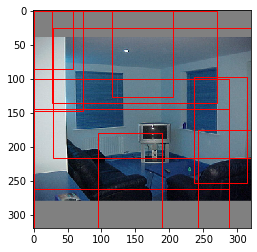

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.imshow(img)
axs = plt.gca()
print(proposal_)
for i in range(10):
    box = proposal_[i]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor='none', edgecolor='r')
    axs.add_patch(rec)